In [1]:
# Following: https://www.youtube.com/watch?v=WyCDsxZb8Gs

In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from typing import List
import easier as ezr
from tqdm import tqdm


    # norm: eqx.nn.BatchNorm
    # dropout: eqx.nn.Dropout

100%|██████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 125.52it/s]


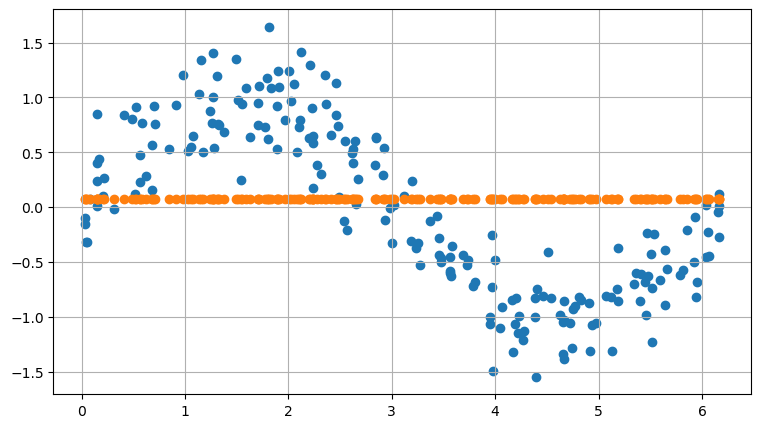

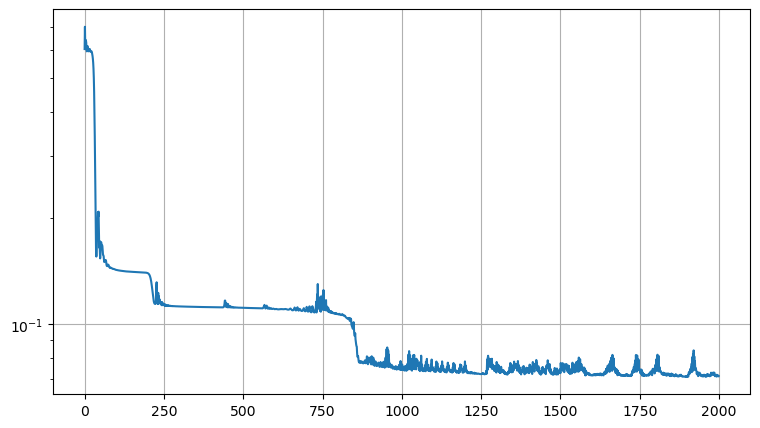

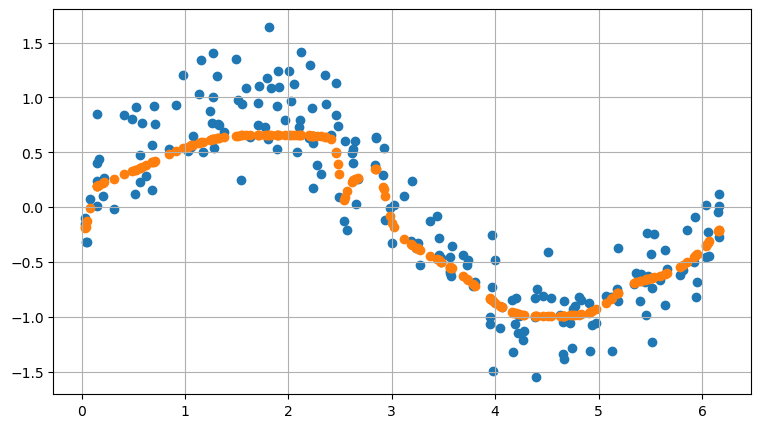

In [39]:

N_SAMPLES = 200
LAYERS = [1, 10, 10, 10, 10, 10, 1]
# LAYERS = [1, 2, 2, 1]

LEARNING_RATE = 0.05
N_EPOCHS = 2_000

key = jax.random.PRNGKey(0)

key = jax.random.PRNGKey(0)
key, xkey, ynoisekey = jax.random.split(key, 3)
x_samples = jax.random.uniform(xkey, shape=(N_SAMPLES, 1), minval=0, maxval=jnp.pi * 2 )
y_samples = jnp.sin(x_samples) + jax.random.normal(ynoisekey, x_samples.shape) * 0.3

class SimpMLP(eqx.Module):
    layers: List[eqx.nn.Linear]
    
    def __init__(self, layer_sizes, key):
        self.layers = []
        
        for (fan_in, fan_out) in zip(layer_sizes[:-1], layer_sizes[1:]):
            key, subkey = jax.random.split(key)
            self.layers.append(
                eqx.nn.Linear(fan_in, fan_out, use_bias=True, key=subkey)
            )
            if (fan_out > 1) and (fan_in > 1):
                self.layers.append(
                    eqx.nn.Dropout(p=.1)
                )
    def __call__(self, x):
        key = jax.random.PRNGKey(40)
        for layer in self.layers[:-1]:
            key, sub_key = jax.random.split(key)
            if isinstance(layer, eqx.nn.Dropout):
                x = layer(x, key=sub_key)
            else:
                x = jax.nn.sigmoid(layer(x))
        x = self.layers[-1](x)
        return x

model = SimpMLP(LAYERS, key=key)


def l2_regularization(model):
    v = [jnp.mean(jnp.square(param)) for param in jax.tree_util.tree_leaves(model)]
    return sum(v) / len(v)

def model_to_loss(m, x, y):
    prediction = jax.vmap(m)(x)
    delta = prediction - y
    loss = jnp.mean(delta ** 2)
    l2_reg = l2_regularization(m)
    return loss #+ .1 * l2_reg

model_to_loss_and_grad = eqx.filter_value_and_grad(model_to_loss)

opt = optax.adam(LEARNING_RATE)
# opt = optax.sgd(LEARNING_RATE, )

opt_state = opt.init(eqx.filter(model, eqx.is_array))


@eqx.filter_jit
def make_step(m, opt_s, x, y):
    loss, grad = model_to_loss_and_grad(m, x, y)
    updates, opt_s = opt.update(grad, opt_s, m)
    m = eqx.apply_updates(m, updates)
    return m, opt_s, loss

ax = ezr.figure()
ax.scatter(x_samples, y_samples)
ax.scatter(x_samples, jax.vmap(model)(x_samples))

loss_history = []
for epoch in tqdm(range(N_EPOCHS), total=N_EPOCHS):
    model, opt_state, loss = make_step(model, opt_state, x_samples, y_samples)
    loss_history.append(loss)

ax = ezr.figure()
ax.semilogy(loss_history)

ax = ezr.figure()
ax.scatter(x_samples, y_samples)
ax.scatter(x_samples, jax.vmap(eqx.nn.inference_mode(model))(x_samples))


In [22]:
# ax = ezr.figure()
# ax.scatter(x_samples, y_samples)
ax.scatter(x_samples, jax.vmap(eqx.nn.inference_mode(model, value=True))(x_samples))
# jax.vmap(eqx.nn.inference_mode(model, value=True))(x_samples)

In [25]:
jax.vmap(eqx.nn.inference_mode(model))(x_samples)

Array([[-0.17859356],
       [ 0.14562261],
       [-0.17978427],
       [ 0.15157104],
       [ 0.07343756],
       [ 0.09593728],
       [ 0.10040252],
       [-0.18095845],
       [-0.06801023],
       [ 0.02680803],
       [ 0.05110522],
       [ 0.10312931],
       [ 0.09411827],
       [-0.05649784],
       [ 0.16073574],
       [-0.1769901 ],
       [-0.09933645],
       [-0.07401104],
       [-0.17597143],
       [-0.18096831],
       [ 0.16197267],
       [ 0.06563893],
       [ 0.15627913],
       [ 0.07974364],
       [ 0.14350136],
       [-0.0711384 ],
       [-0.0905922 ],
       [-0.12084451],
       [-0.10180019],
       [ 0.11846623],
       [ 0.15054   ],
       [-0.18060705],
       [-0.1590425 ],
       [ 0.0997235 ],
       [ 0.04538624],
       [ 0.09016038],
       [ 0.10741602],
       [-0.03433274],
       [-0.17746197],
       [-0.1765667 ],
       [ 0.13799068],
       [-0.16315126],
       [ 0.13259403],
       [ 0.08991112],
       [-0.17556298],
       [-0